In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prim
import seaborn as sns
from sklearn import mixture

In [2]:
%matplotlib inline

In [3]:
sns.set_context("poster",rc={"font.size": 28})
sns.set_style("whitegrid")

## Prepare data

In [4]:
data = pd.read_excel("C:\\Users\\WB451855\\OneDrive - WBG\\!infra_needs_data\\energy_kth_output_data\\SAMBA scenario results all runs_revised CO2 limit.xlsx","Capital inv variable and fixed")

In [5]:
gdp = pd.read_excel("C:\\Users\\WB451855\\OneDrive - WBG\\!infra_needs_data\\energy_kth_output_data\\GDPs.xlsx")

### Sets up the GDP data (sums for the region and puts years in columns)

In [6]:
gdp1 = gdp.loc[(gdp.Parameter=="GDP billion USD")|(gdp.Parameter=="GDP"),:].set_index(["Scenario","Country"]).drop("Parameter",axis=1)

In [7]:
gdp1.columns.name='year'

In [8]:
gdp2 = gdp1.stack()

In [9]:
reg_gdp = gdp2.sum(level=["Scenario","year"])

In [10]:
reg_gdp.name="gdp"

In [11]:
reg_gdp = reg_gdp.reset_index()

SSP3 is the lowest demand, SSP2 the medium demand and SSP1 the highest demand

In [12]:
reg_gdp["DMD"] = reg_gdp.Scenario.replace({"SSP3":1,"SSP2":2,"SSP1":3})

### sets up the investment data

In [13]:
data = data.set_index(['DMD', 'FUEL', 'CC RE', 'DR', 'CO2', 'CC', 'Parameter (million USD)'])
data.columns.name = 'year'

In [14]:
data = data.stack('year')
data.name = 'value'

In [15]:
data = data.reset_index()
data['year'] = data.year.astype("int64")

### Merge GDP and investment data and divide investment value by GDP

In [16]:
bigger_data = reg_gdp.merge(data,on=['DMD','year'],how='outer')

In [17]:
bigger_data["divided_by_gdp"] = 10**(-3)*bigger_data.value/bigger_data.gdp

In [18]:
bigger_data.divided_by_gdp.describe()

count    36936.000000
mean         0.003949
std          0.002844
min          0.000006
25%          0.001515
50%          0.003146
75%          0.005735
max          0.023255
Name: divided_by_gdp, dtype: float64

after 2025 capital investments are more than 10% of GDP in all scenarios!!

In [19]:
bigger_data.loc[bigger_data.divided_by_gdp>0.10,:]

,Scenario,year,gdp,DMD,FUEL,CC RE,DR,CO2,CC,Parameter (million USD),value,divided_by_gdp


### discounts

In [20]:
d = 0.06
bigger_data["discount_factor"] = (1+d)**(1-(bigger_data.year-2012))

In [21]:
bigger_data["discounted_value"] = bigger_data.value*bigger_data.discount_factor

In [22]:
data.year.unique()

array([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023,
       2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034,
       2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045,
       2046, 2047, 2048, 2049, 2050], dtype=int64)

### Takes the discounted sum

In [23]:
new_data2030 = bigger_data.loc[bigger_data.year.astype(float)<2031,:].set_index(['DMD', 'FUEL', 'CC RE', 'DR', 'CO2', 'CC', 'Parameter (million USD)']).discounted_value.sum(level=['DMD', 'FUEL', 'CC RE', 'DR', 'CO2', 'CC', 'Parameter (million USD)']).unstack("Parameter (million USD)").reset_index()

In [24]:
new_data = bigger_data.set_index(['DMD', 'FUEL', 'CC RE', 'DR', 'CO2', 'CC', 'Parameter (million USD)']).discounted_value.sum(level=['DMD', 'FUEL', 'CC RE', 'DR', 'CO2', 'CC', 'Parameter (million USD)']).unstack("Parameter (million USD)").reset_index()

### Takes the average of GDP shares

In [25]:
new_data2030_gdp = bigger_data.loc[bigger_data.year.astype(float)<2031,:].set_index(['DMD', 'FUEL', 'CC RE', 'DR', 'CO2', 'CC', 'Parameter (million USD)']).divided_by_gdp.mean(level=['DMD', 'FUEL', 'CC RE', 'DR', 'CO2', 'CC', 'Parameter (million USD)']).unstack("Parameter (million USD)").reset_index()

In [26]:
inputs = new_data[['DMD', 'FUEL', 'CC RE', 'DR', 'CO2', 'CC']]

## results (costs)

In [27]:
new_data[['CapitalInvestment','AnnualFixedOperatingCost','AnnualVariableOperatingCost']].describe()

Parameter (million USD),CapitalInvestment,AnnualFixedOperatingCost,AnnualVariableOperatingCost
count,3.240000e+02,324.000000,324.000000
mean,6.540085e+05,140250.300676,343650.695148
std,1.463792e+05,8435.880516,61490.805437
min,4.593265e+05,123993.336826,265573.679013
25%,5.456507e+05,133773.394219,299689.070437
50%,6.153911e+05,139659.728606,324868.136535
75%,7.233889e+05,144708.575480,371229.781523
max,1.184594e+06,162493.071318,534280.521865


In [28]:
new_data['tot_cost'] = new_data[['CapitalInvestment','AnnualFixedOperatingCost','AnnualVariableOperatingCost']].sum(axis=1)

In [29]:
new_data2030['tot_cost'] = new_data2030[['CapitalInvestment','AnnualFixedOperatingCost','AnnualVariableOperatingCost']].sum(axis=1)
new_data2030['annual_cost'] = new_data2030[['AnnualFixedOperatingCost','AnnualVariableOperatingCost']].sum(axis=1)

In [30]:
new_data2030_gdp['tot_cost'] = new_data2030_gdp[['CapitalInvestment','AnnualFixedOperatingCost','AnnualVariableOperatingCost']].sum(axis=1)
new_data2030_gdp['annual_cost'] = new_data2030_gdp[['AnnualFixedOperatingCost','AnnualVariableOperatingCost']].sum(axis=1)

In [31]:
1/(2030-2012)*new_data2030.tot_cost.describe()

count       18.000000
mean     36763.621957
std       2670.615554
min      33031.320149
25%      34864.191286
50%      36545.369214
75%      38105.493190
max      46987.461873
Name: tot_cost, dtype: float64

In [32]:
new_data['tot_cost'].describe()

count    3.240000e+02
mean     1.137909e+06
std      1.631190e+05
min      9.115597e+05
25%      1.012962e+06
50%      1.117834e+06
75%      1.234070e+06
max      1.702259e+06
Name: tot_cost, dtype: float64

In [33]:
new_data['annual_cost'] = new_data[['AnnualFixedOperatingCost','AnnualVariableOperatingCost']].sum(axis=1)

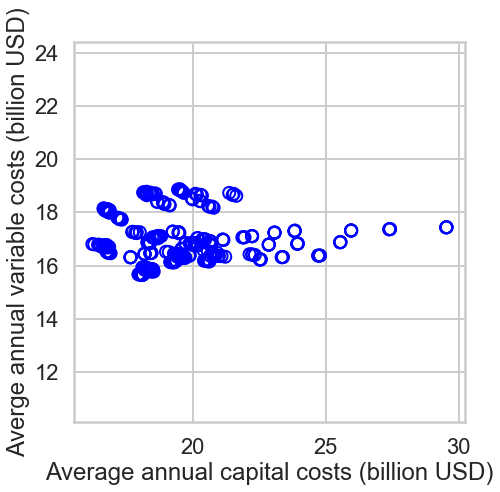

In [35]:
toplot = 10**(-3)*new_data2030[['CapitalInvestment','annual_cost']]*1/(2030-2012)

plt.figure(figsize=(7,7))
plt.scatter(toplot.CapitalInvestment,toplot.annual_cost,marker="o",facecolors='none',edgecolor="b")
plt.axis('equal')
plt.xlabel("Average annual capital costs (billion USD)")
plt.ylabel("Averge annual variable costs (billion USD)")

plt.savefig("KTH_capital_vs_variable2030.png",ddpi=300,bbox_inches="tight")
plt.savefig("KTH_capital_vs_variable2030.pdf")
plt.savefig("C:\\Users\\WB451855\\OneDrive - WBG\\infrastructure needs\\infra_needs_writing_process\\graphs\\Chapter 3\\Fig_3_15.eps")

In [37]:
toplot.to_csv("fig3_15.csv")

In [165]:
new_data.sample(3)

Parameter (million USD),DMD,FUEL,CC RE,DR,CO2,CC,AnnualFixedOperatingCost,AnnualVariableOperatingCost,CapitalInvestment,tot_cost,annual_cost
198,2,3,3,1,1,1,149914.320715,294507.412530,6.821604e+05,1.126582e+06,444421.733245
312,3,3,3,2,1,1,158005.123245,327790.549009,1.001312e+06,1.487108e+06,485795.672253
266,3,1,3,3,2,1,139658.475235,453915.131020,9.223151e+05,1.515889e+06,593573.606255


In [166]:
new_data2030_gdp.describe()

Parameter (million USD),DMD,FUEL,CC RE,DR,CO2,CC,AnnualFixedOperatingCost,AnnualVariableOperatingCost,CapitalInvestment,tot_cost,annual_cost
count,324.00000,324.000000,324.00000,324.00000,324.00000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000
mean,2.00000,2.000000,2.00000,2.00000,2.00000,1.500000,0.001465,0.003541,0.006030,0.011036,0.005006
std,0.81776,1.001547,0.81776,0.81776,0.81776,0.500773,0.000040,0.000326,0.000795,0.000801,0.000292
min,1.00000,1.000000,1.00000,1.00000,1.00000,1.000000,0.001397,0.003095,0.004932,0.009931,0.004594
25%,1.00000,1.000000,1.00000,1.00000,1.00000,1.000000,0.001431,0.003262,0.005561,0.010479,0.004777
50%,2.00000,2.000000,2.00000,2.00000,2.00000,1.500000,0.001462,0.003504,0.005885,0.010912,0.004959
75%,3.00000,3.000000,3.00000,3.00000,3.00000,2.000000,0.001499,0.003639,0.006299,0.011406,0.005105
max,3.00000,3.000000,3.00000,3.00000,3.00000,2.000000,0.001542,0.004201,0.009104,0.014212,0.005622


C:\ProgramData\Anaconda3\envs\Julie1\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\envs\Julie1\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


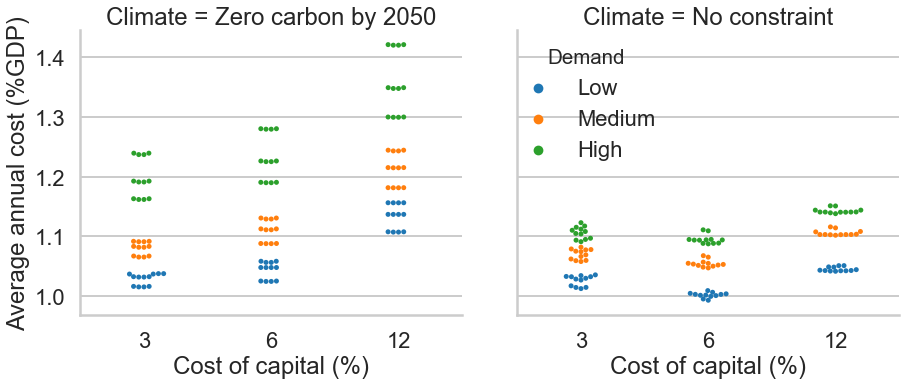

In [38]:
to_plot = new_data2030_gdp.loc[new_data2030.CO2!=2,:].copy()
#to_plot["tot_cost"] = 1/(2030-2012)*10**(-3)*to_plot.tot_cost
to_plot["tot_cost"] = 100*to_plot.tot_cost

to_plot["DR"] = to_plot["DR"].replace({1:3,2:6,3:12})

to_plot["DMD"] = to_plot["DMD"].replace({1:"Low",2:"Medium",3:"High"})

to_plot["CO2"] = to_plot["CO2"].replace({1:"Zero carbon by 2050",3:"No constraint"})

g = sns.factorplot(x='DR',y='tot_cost', hue= 'DMD', col="Climate", data=to_plot.rename(columns={"CO2":"Climate"}), kind="swarm",dodge=False, size=6, aspect=1.1,\
                  legend=False)

g.set_axis_labels("Cost of capital (%)", "Average annual cost (%GDP)")
g.add_legend(title="Demand",bbox_to_anchor=(0.6, 0.65), borderaxespad=0.)

plt.savefig("KTH_costs2030_gdp.png",ddpi=300,bbox_inches="tight")
plt.savefig("KTH_costs2030_gdp.pdf")
plt.savefig("C:\\Users\\WB451855\\OneDrive - WBG\\infrastructure needs\\infra_needs_writing_process\\graphs\\Chapter 3\\Fig_3_16.eps")

In [40]:
to_plot.to_csv("fig3_16.csv")

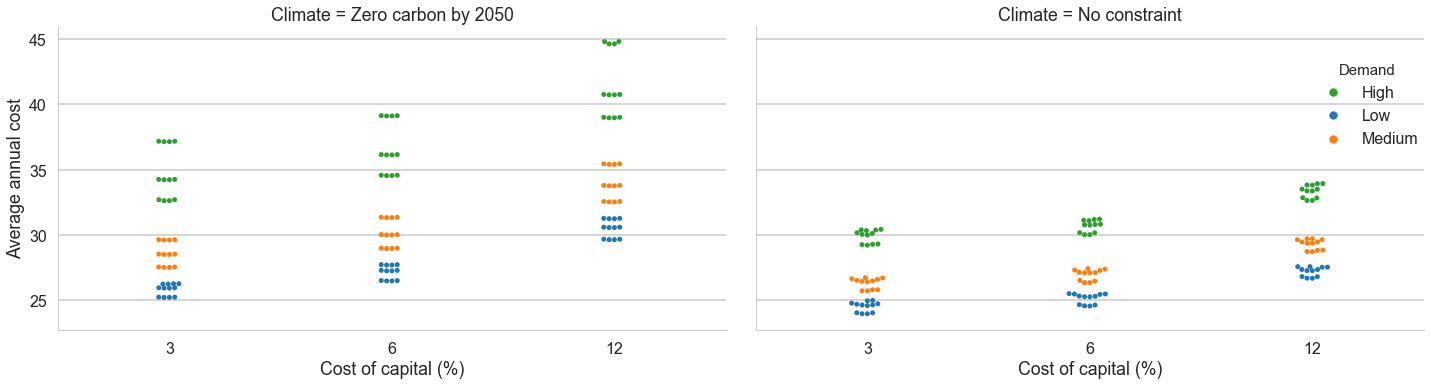

In [21]:
to_plot = new_data.loc[new_data.CO2!=2,:].copy()
to_plot["tot_cost"] = 1/(2050-2012)*10**(-3)*to_plot.tot_cost

to_plot["DR"] = to_plot["DR"].replace({1:3,2:6,3:12})

to_plot["DMD"] = to_plot["DMD"].replace({1:"Low",2:"Medium",3:"High"})

to_plot["CO2"] = to_plot["CO2"].replace({1:"Zero carbon by 2050",3:"No constraint"})

g = sns.factorplot(x='DR',y='tot_cost', hue= 'DMD', col="Climate", data=to_plot.rename(columns={"CO2":"Climate"}), kind="swarm",dodge=False, size=6, aspect=1.7,\
                  legend=False)

g.set_axis_labels("Cost of capital (%)", "Average annual cost")
g.add_legend(title="Demand",bbox_to_anchor=(0.9, 0.65), borderaxespad=0.)

plt.savefig("KTH_costs.png",ddpi=300,bbox_inches="tight")
plt.savefig("KTH_costs.pdf")

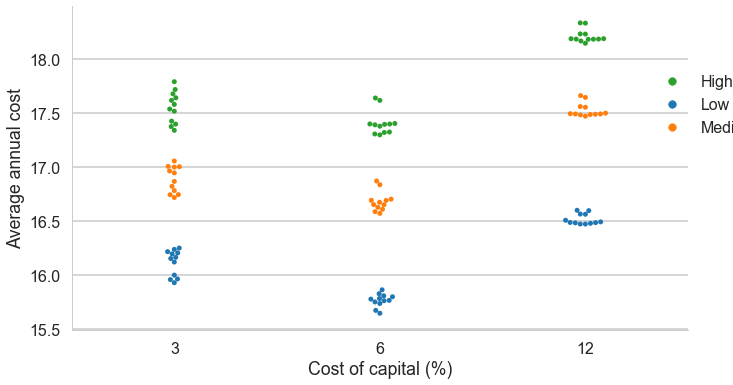

In [129]:
to_plot = new_data.loc[new_data.CO2==3,:].copy()
to_plot["tot_cost"] = 1/(2050-2012)*10**(-3)*to_plot.tot_cost

to_plot["DR"] = to_plot["DR"].replace({1:3,2:6,3:12})

to_plot["DMD"] = to_plot["DMD"].replace({1:"Low",2:"Medium",3:"High"})

g = sns.factorplot(x='DR',y='tot_cost', hue= 'DMD', data=to_plot, kind="swarm",dodge=False, size=6, aspect=1.7,\
                  legend=False)

g.set_axis_labels("Cost of capital (%)", "Average annual cost")
g.add_legend(title="",bbox_to_anchor=(0.9, 0.65), borderaxespad=0.)

### clustering and scenario discovery functions 

In [78]:
def normalize(data):
    minima = np.min(data, axis=0)
    maxima = np.max(data, axis=0)
    a = 1/(maxima-minima)
    b = minima/(minima-maxima)
    data = a * data + b                    
    return data

def clustering(n_clusters,data,xstring,ystring):
    data_norm = normalize(data)
    g = mixture.GaussianMixture(n_components=n_clusters)
    #g = mixture.GaussianMixture(n_components=n_clusters,random_state = 0)
    g.fit(data_norm)
    pred = g.predict(data_norm)+1
                    
    x=[]
    y=[]
    for i in range(0,len(data)):
        x.append(data[i][0])
        y.append(data[i][1])

    df = pd.DataFrame()
    df[xstring] = x
    df[ystring] = y
    df['class'] = pred
    
    return df

In [40]:
def get_prim(n_clusters, f_value,data,xstring,ystring,inputs):
    
    df = clustering(n_clusters,data,xstring,ystring)
    list_prim =[]
        
    for i in range(1,df['class'].max()+1):
        list_prim.append(prim.Prim(inputs, (df['class']==i),threshold=0.5,threshold_type=">"))

    boxes = []

    for i in range(0,len(list_prim)):
        boxes.append(list_prim[i].find_box())
        obj = (f_value*boxes[i].peeling_trajectory['coverage']-(1-f_value)*boxes[i].peeling_trajectory['density'])**2
        if 1 in boxes[i].peeling_trajectory['coverage']:
            coverage1 = np.where(boxes[i].peeling_trajectory['coverage']==1)[0][0]
            obj = obj.drop(obj.index[[coverage1]])
        k = obj.argmin()
        boxes[i].select(k)
    
    return [boxes,df]

### looking for the clusters that gives the best PRIM results (we run the clustering several times until we get the best prim results) 

In [18]:
oois = ['annual_cost','CapitalInvestment']

data = np.array([[new_data[oois[0]][0],new_data[oois[1]][0]]])
for i in range(1,len(new_data.index)):
    data = np.concatenate((data,np.array([[new_data[oois[0]][i],new_data[oois[1]][i]]])))

In [67]:
n_clusters = 4
f_value = 0.5
seuil = 1.2

In [79]:
boxes_out,df_out = get_prim(n_clusters, f_value, data,oois[0],oois[1],inputs)

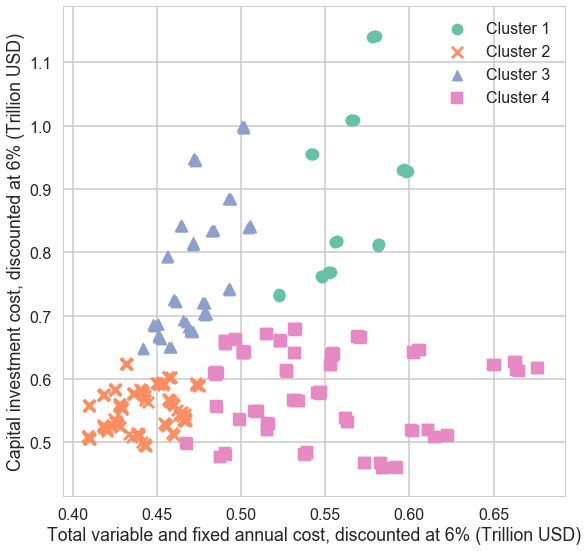

In [94]:
f = plt.figure(figsize=(9,9))
mycolors = ["#66c2a5","#fc8d62","#8da0cb","#e78ac3"]
mymarks = ["o","x","^","s"]
for (i,subdf) in df_out.groupby("class"):
    plt.scatter(1e-6*subdf.annual_cost,1e-6*subdf.CapitalInvestment,label="Cluster {}".format(i),c=mycolors[i-1],marker=mymarks[i-1])
    
plt.legend()
plt.xlabel("Total variable and fixed annual cost, discounted at 6% (Trillion USD)")
plt.ylabel("Capital investment cost, discounted at 6% (Trillion USD)")
plt.savefig("clusters_discounted_6.png")

### below are PRIM results for each cluster

#### cluster 1  

In [81]:
boxes_out[0].limits

,min,max,qp values
DR,3.0,3.0,5.231633e-13
CO2,1.0,2.0,3.586348e-04
DMD,2.0,3.0,3.586348e-04


In [82]:
boxes_out[0].coverage,boxes_out[0].density

(1.0, 0.75)

#### cluster 2 

In [83]:
boxes_out[1].limits

,min,max,qp values
DMD,1.0,2.0,1.731957e-09
DR,1.0,2.0,1.731957e-09


In [84]:
boxes_out[1].coverage,boxes_out[1].density

(1.0, 0.73611111111111116)

#### cluster 3 

In [85]:
boxes_out[2].limits

,min,max,qp values
DMD,2.0,3.0,0.000002
DR,1.0,2.0,0.000002
CO2,1.0,2.0,0.000235


In [86]:
boxes_out[2].coverage,boxes_out[2].density

(0.89473684210526316, 0.70833333333333337)

In [87]:
boxes_out[3].limits

,min,max,qp values
DR,2.0,3.0,0.000004
CO2,2.0,3.0,0.000162


In [88]:
boxes_out[3].coverage,boxes_out[3].density

(0.84905660377358494, 0.625)

In [90]:
table_out = pd.DataFrame()

In [93]:
table_out.append(pd.DataFrame(boxes_out[0]))

PandasError: DataFrame constructor not properly called!